In [1]:
import sys
sys.path.append("../")

In [2]:
import torch
import os
import cv2
import PIL
import json
import numpy as np
import matplotlib.pyplot as plt
from visdial.model import get_model
from visdial.utils import move_to_cuda
from torch.utils.data import DataLoader
from PIL import Image
from visdial.model import get_model
from visdial.data import VisDialDataset
from visdial.utils.image_utils import *
dir_path = '/home/quang/datasets/raw_images/VisualDialog_val2018'
pattern = 'VisualDialog_val2018_000000{:06d}.jpg'

def untokenize(ids):
    "ids: numpy array"
    tokens = " ".join(dataset.tokenizer.convert_ids_to_tokens(ids))
    tokens = tokens.replace('<PAD>', ' ')
    return tokens


In [3]:
config_path = '/home/quang/checkpoints/abci/s41/config.json'
with open(config_path) as file:
    config = json.load(file)

In [4]:
dataset = VisDialDataset(config, split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

[val2018] Tokenizing questions...
[val2018] Tokenizing answers...
[val2018] Tokenizing captions...
genome_path None


In [410]:
config['model']['debug'] = True

model = get_model(config)
model.decoder.gen_decoder = None

model.load_state_dict(torch.load('/home/quang/checkpoints/abci/s41/checkpoint_13.pth')['model'])

device = 'cuda:0'
model = model.to(device)
model = model.eval()

In [462]:
for batch in dataloader:
    break

img_id = batch['img_ids'][0]
boxes = batch['boxes'][0].numpy()
img_path = img_id_to_path(img_id, dir_path, pattern)
img = Image.open(img_path)

batch = move_to_cuda(batch, device)
output = model(batch)
w_a = model.encoder.attn_encoder.cross_attn_encoder[0].attns[0].attn_X_guided_by_Y
w_b = model.encoder.attn_encoder.cross_attn_encoder[1].attns[0].attn_X_guided_by_Y
print(batch["img_ids"])

tensor([138429], device='cuda:0')


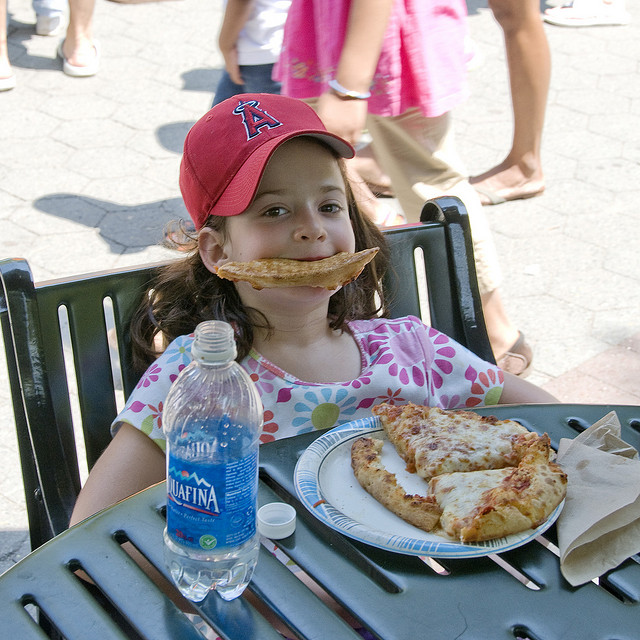

In [463]:
img

In [464]:
for i, tokens in enumerate(batch['ques_tokens'][0]):
    print(i, untokenize(tokens.cpu().numpy()))

0 is the girl sitting by herself ?                          
1 is she at home or in a restaurant ?                      
2 what color is her hair ?                            
3 is her hair long or short ?                          
4 what kind of pizza is she eating ?                        
5 has she finished almost all of the pizza ?                      
6 is she wearing glasses ?                              
7 what color is her shirt or dress ?                        
8 are there any other people around ?                          
9 is it sunny ?                                


In [466]:
ques_idx  = 2
ques_tokens = batch['ques_tokens'][0][ques_idx]
for idx, word in enumerate(dataset.tokenizer.convert_ids_to_tokens(ques_tokens.cpu().numpy())[:-5]):
    if word == '<PAD>':
        break
    print(idx, word)

0 what
1 color
2 is
3 her
4 hair
5 ?


In [471]:
mem_size = 2
word_idx = 4
scores = w_a[ques_idx][mem_size:, mem_size + word_idx]

<BarContainer object of 100 artists>

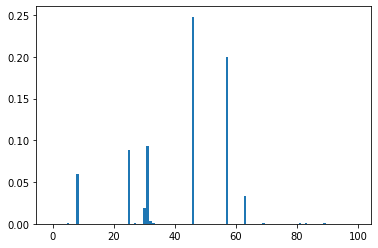

In [472]:
scores = scores.data.cpu().numpy()
plt.bar(np.arange(100), scores)

[57 46]


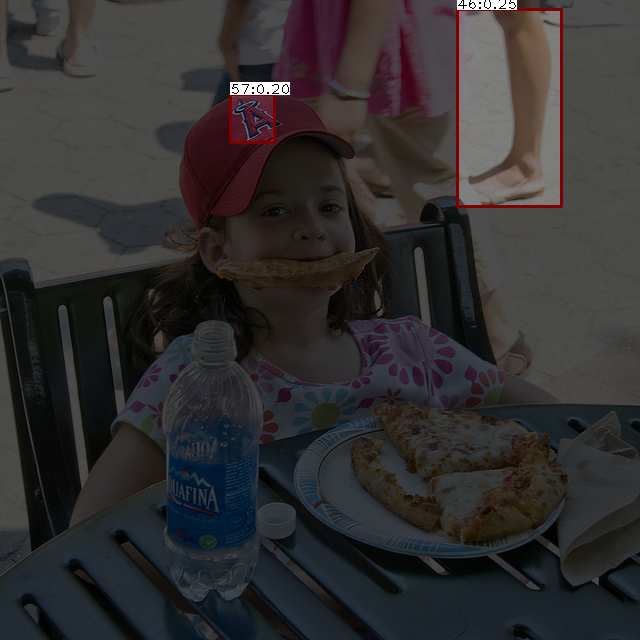

In [474]:
Image.fromarray(draw_boxes_with_scores(np.array(img), boxes, scores, topk=2))

In [458]:
def draw_boxes_with_scores(img, boxes, scores, topk=5, skip_indices=[]):
    """
    Args:
        img (np.array) [H, W, 3]
        boxes (np.array) [num_boxes, 4] a box is represented by (x1, y1, x2, y2)
        scores (np.array) [num_boxes,]
        topk: top boxes with the highest scores.

    Return:
        new_img: (np.array)
    """
    new_img = (img * 0.3).astype('uint8')

    # sorting
    selection = np.argsort(scores)[-topk:]
    print(selection)
    alpha_scores = np.array([0.5, 0.5, 0.75, 0.75, 1.0])

    for al_idx, i in enumerate(selection):
        if i in skip_indices:
            continue
        al_score = alpha_scores[al_idx]
        box = boxes[i]
        score = scores[i]
        # draw the region
        box = box.astype(int)
        x1, y1, x2, y2 = box
        new_img[y1:y2, x1:x2] = (img[y1:y2, x1:x2] * al_score).astype('uint8')
        cv2.rectangle(new_img, (x1, y1), (x2, y2), color=(int(al_score * 255), 0, 0), thickness=2)

        # Add text
        font_scale = 1.0
        font_face = cv2.FONT_HERSHEY_PLAIN
        text = "{}:{:1.2f}".format(i, score)

        # get the width and height of the text box
        tw, th = cv2.getTextSize(text, font_face, font_scale, thickness=1)[0]

        # set the text start position
        tx1, ty1 = x1, y1
        tx2, ty2 = tx1 + tw - 2, ty1 - th - 2

        # draw the text box
        cv2.rectangle(new_img, (tx1, ty1), (tx2, ty2), (255,255,255), cv2.FILLED)

        # draw teh text
        cv2.putText(new_img, text, (tx1, ty1), font_face, font_scale, (0, 0, 0),thickness=1)
    return new_img